### Detecting suicide ideation in online posts from Reddit using Vader (unsupervised learning) and ML

In [1]:
!pip install -qqq unidecode

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
# AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import pickle
import string
import re
import unidecode

# Text Processing libraries
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
df = pd.read_csv('Suicide_Detection.csv',encoding='utf-8',engine='python')

print(df.shape)

df = df.sample(6000, random_state=47)
df.drop('Unnamed: 0', axis=1,inplace=True)
df.head()

(232074, 3)


,text,class
173441,How to beat NO NUT NOVEMBER Alright lads I may...,non-suicide
45677,Friends today were joking about suicide.I have...,suicide
129396,"I hate myself.Alright, just going to cut to th...",suicide
85509,If anyone wants to talkSo recently I've joined...,suicide
228470,Random question for the nonvirgins of the sub ...,non-suicide


In [4]:
df.reset_index(inplace=True,drop=True)

In [5]:
df[df['text'].isnull()].index

Int64Index([], dtype='int64')

In [6]:
df.to_csv('suicide_detection_modified.csv')

In [7]:
def rem_whitespace(text):
    text = text.strip()
    return " ".join(text.split())

def rem_url(text):
    return re.sub(r'http\S+', '', text)

def rem_email(text):
    return re.sub(r'\S+@\S+', '', text)

def rem_symbols_digits(text):
    return re.sub('[^a-zA-Z\s]', ' ', text)

def rem_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def rem_special(text):
    return text.replace("\r", " ").replace("\n", " ").replace("    ", " ").replace('"', '')

def rem_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

def fix_lengthening(text):
     return re.sub(r"(.)\1{2,}",r'\1',text)


In [8]:
from nltk import word_tokenize, sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
df['text'] =  df['text'].str.lower()

In [10]:
# Looking at a sample tweet
df['text'][30]

"katy perry gush :) ***hey guys, gals, and non binary pals :)***\n\nso i'm bored and listening to music and i've recently started listening to some old katy perry songs that came out back when i was little. anddddd i have quite a lot to say about them. :) nobody probably cares tho lol. but basically, i'm just gonna be gushing about her songs and lyrics cuz why not? if you're not interested, you can keep scrolling and ignore this lol. i'm open to having a discussion or gush afterwards in the comments if you end up reading my post. either way, hope you all have a great rest of your day/night! :)\n\nso to begin: i absolutely love how the majority of her songs are about empowering women and just so motivational. i feel like i've always been strong or known my worth, so i was able to relate to her songs. and then other songs are just really fun! no big message or anything, just for fun! now let us beginnn\n\n**part of me:** basically about how she's leaving her cheating bf according to the 

In [11]:
df['text']   = df['text'].apply(lambda t : rem_emoji(t))
df['text']   = df['text'].apply(lambda t : rem_symbols_digits(t))
df['text']   = df['text'].apply(lambda t : rem_url(t))
df['text']   = df['text'].apply(lambda t : rem_email(t))
df['text']   = df['text'].apply(lambda t : rem_special(t))
df['text']   = df['text'].apply(lambda t : rem_accented_chars(t))
df['text']   = df['text'].apply(lambda t : fix_lengthening(t))
df['text']   = df['text'].apply(lambda t : rem_whitespace(t))

In [12]:
#Checking the cleaned data..

df['text'][30]

'katy perry gush hey guys gals and non binary pals so i m bored and listening to music and i ve recently started listening to some old katy perry songs that came out back when i was little and i have quite a lot to say about them nobody probably cares tho lol but basically i m just gonna be gushing about her songs and lyrics cuz why not if you re not interested you can keep scrolling and ignore this lol i m open to having a discussion or gush afterwards in the comments if you end up reading my post either way hope you all have a great rest of your day night so to begin i absolutely love how the majority of her songs are about empowering women and just so motivational i feel like i ve always been strong or known my worth so i was able to relate to her songs and then other songs are just really fun no big message or anything just for fun now let us begin part of me basically about how she s leaving her cheating bf according to the music video and talking about how life and people can be 

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [15]:
df['text'] = df['text'].apply(lambda x:nltk.word_tokenize(x))

In [16]:
df['text'][30]

['katy',
 'perry',
 'gush',
 'hey',
 'guys',
 'gals',
 'non',
 'binary',
 'pals',
 'bored',
 'listening',
 'music',
 'recently',
 'started',
 'listening',
 'old',
 'katy',
 'perry',
 'songs',
 'came',
 'back',
 'little',
 'quite',
 'lot',
 'say',
 'nobody',
 'probably',
 'cares',
 'tho',
 'lol',
 'basically',
 'gon',
 'na',
 'gushing',
 'songs',
 'lyrics',
 'cuz',
 'interested',
 'keep',
 'scrolling',
 'ignore',
 'lol',
 'open',
 'discussion',
 'gush',
 'afterwards',
 'comments',
 'end',
 'reading',
 'post',
 'either',
 'way',
 'hope',
 'great',
 'rest',
 'day',
 'night',
 'begin',
 'absolutely',
 'love',
 'majority',
 'songs',
 'empowering',
 'women',
 'motivational',
 'feel',
 'like',
 'always',
 'strong',
 'known',
 'worth',
 'able',
 'relate',
 'songs',
 'songs',
 'really',
 'fun',
 'big',
 'message',
 'anything',
 'fun',
 'let',
 'us',
 'begin',
 'part',
 'basically',
 'leaving',
 'cheating',
 'bf',
 'according',
 'music',
 'video',
 'talking',
 'life',
 'people',
 'really',
 'cra

In [17]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
wl = WordNetLemmatizer()

In [19]:
df['text'] = df['text'].apply(lambda x: [wl.lemmatize(i) for i in x])

In [20]:
df['text']=df['text'].apply(lambda x : ' '.join(x))

In [21]:
df.to_csv('suicide_clean.csv')

In [22]:
# from sklearn.preprocessing import LabelEncoder

# le=LabelEncoder()

# df['class']=le.fit_transform(df['class'])

In [23]:
!pip install vaderSentiment

In [24]:
# Importing Vader

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sent_analyser = SentimentIntensityAnalyzer()

In [25]:
num_rows = df.shape[0]
score_vector = []
for i in range(num_rows):
    score = sent_analyser.polarity_scores(df.loc[i,'text'])
    print(score)
    score_vector.append(score['compound'])


df.loc[:,'sentiment'] = score_vector
df

{'neg': 0.138, 'neu': 0.691, 'pos': 0.171, 'compound': -0.0772}
{'neg': 0.227, 'neu': 0.543, 'pos': 0.23, 'compound': -0.8484}
{'neg': 0.233, 'neu': 0.582, 'pos': 0.185, 'compound': -0.8465}
{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.8225}
{'neg': 0.335, 'neu': 0.665, 'pos': 0.0, 'compound': -0.891}
{'neg': 0.358, 'neu': 0.439, 'pos': 0.202, 'compound': -0.9309}
{'neg': 0.164, 'neu': 0.648, 'pos': 0.188, 'compound': 0.9292}
{'neg': 0.355, 'neu': 0.318, 'pos': 0.327, 'compound': 0.0}
{'neg': 0.167, 'neu': 0.321, 'pos': 0.513, 'compound': 0.6597}
{'neg': 0.23, 'neu': 0.638, 'pos': 0.132, 'compound': -0.8123}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.68, 'pos': 0.32, 'compound': 0.9509}
{'neg': 0.272, 'neu': 0.557, 'pos': 0.171, 'compound': -0.836}
{'neg': 0.447, 'neu': 0.386, 'pos': 0.167, 'compound': -0.8261}
{'neg': 0.417, 'neu': 0.359, 'pos': 0.225, 'compound': -0.9173}
{'neg': 0.0, 'neu': 0.464, 'pos': 0.536, 'compound': 0.7964}
{'neg': 0

{'neg': 0.153, 'neu': 0.467, 'pos': 0.38, 'compound': 0.9977}
{'neg': 0.461, 'neu': 0.307, 'pos': 0.232, 'compound': -0.7351}
{'neg': 0.645, 'neu': 0.355, 'pos': 0.0, 'compound': -0.8442}
{'neg': 0.297, 'neu': 0.448, 'pos': 0.255, 'compound': -0.8271}
{'neg': 0.342, 'neu': 0.658, 'pos': 0.0, 'compound': -0.8074}
{'neg': 0.251, 'neu': 0.519, 'pos': 0.23, 'compound': -0.9428}
{'neg': 0.422, 'neu': 0.39, 'pos': 0.188, 'compound': -0.5574}
{'neg': 0.36, 'neu': 0.548, 'pos': 0.092, 'compound': -0.7783}
{'neg': 0.197, 'neu': 0.507, 'pos': 0.296, 'compound': 0.934}
{'neg': 0.151, 'neu': 0.616, 'pos': 0.233, 'compound': 0.296}
{'neg': 0.164, 'neu': 0.488, 'pos': 0.348, 'compound': 0.9722}
{'neg': 0.111, 'neu': 0.723, 'pos': 0.166, 'compound': 0.6798}
{'neg': 0.459, 'neu': 0.492, 'pos': 0.049, 'compound': -0.8962}
{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.9682}
{'neg': 0.345, 'neu': 0.428, 'pos': 0.227, 'compound': -0.949}
{'neg': 0.254, 'neu': 0.368, 'pos': 0.378, 'compound': 0.86

{'neg': 0.124, 'neu': 0.817, 'pos': 0.059, 'compound': -0.6908}
{'neg': 0.042, 'neu': 0.546, 'pos': 0.412, 'compound': 0.9638}
{'neg': 0.056, 'neu': 0.737, 'pos': 0.207, 'compound': 0.6486}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.258, 'neu': 0.435, 'pos': 0.307, 'compound': 0.1605}
{'neg': 0.231, 'neu': 0.203, 'pos': 0.566, 'compound': 0.9169}
{'neg': 0.465, 'neu': 0.306, 'pos': 0.229, 'compound': -0.92}
{'neg': 0.122, 'neu': 0.878, 'pos': 0.0, 'compound': -0.5994}
{'neg': 0.371, 'neu': 0.515, 'pos': 0.113, 'compound': -0.7184}
{'neg': 0.266, 'neu': 0.503, 'pos': 0.232, 'compound': -0.7201}
{'neg': 0.396, 'neu': 0.208, 'pos': 0.396, 'compound': 0.0}
{'neg': 0.348, 'neu': 0.485, 'pos': 0.167, 'compound': -0.9692}
{'neg': 0.32, 'neu': 0.205, 'pos': 0.475, 'compound': 0.765}
{'neg': 0.244, 'neu': 0.449, 'pos': 0.307, 'compound': 0.2004}
{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}
{'neg': 0.101, 'neu': 0.629, 'pos': 0.27, 'compound': 0.9042}
{'neg':

{'neg': 0.315, 'neu': 0.428, 'pos': 0.257, 'compound': -0.3523}
{'neg': 0.223, 'neu': 0.528, 'pos': 0.249, 'compound': 0.4767}
{'neg': 0.217, 'neu': 0.529, 'pos': 0.254, 'compound': 0.2815}
{'neg': 0.332, 'neu': 0.593, 'pos': 0.075, 'compound': -0.7579}
{'neg': 0.163, 'neu': 0.684, 'pos': 0.154, 'compound': 0.068}
{'neg': 0.318, 'neu': 0.523, 'pos': 0.159, 'compound': -0.7665}
{'neg': 0.323, 'neu': 0.551, 'pos': 0.125, 'compound': -0.7845}
{'neg': 0.0, 'neu': 0.553, 'pos': 0.447, 'compound': 0.836}
{'neg': 0.167, 'neu': 0.667, 'pos': 0.167, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.742, 'pos': 0.258, 'compound': 0.6808}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.172, 'neu': 0.531, 'pos': 0.297, 'compound': 0.9697}
{'neg': 0.18, 'neu': 0.655, 'pos': 0.165, 'compound': -0.8208}
{'neg': 0.3, 'neu': 0.543, 'pos': 0.157, 'compound': -0.9454}
{'neg': 0.3, 'neu': 0.43, 'pos': 0.269, 'compound': -0.9069}
{'neg': 0.105, 'neu': 0.51, 'pos': 0.385, 'compound': 0.9305}
{'neg': 0.

{'neg': 0.27, 'neu': 0.478, 'pos': 0.252, 'compound': -0.9596}
{'neg': 0.359, 'neu': 0.641, 'pos': 0.0, 'compound': -0.9576}
{'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'compound': -0.6705}
{'neg': 0.154, 'neu': 0.505, 'pos': 0.341, 'compound': 0.9376}
{'neg': 0.14, 'neu': 0.825, 'pos': 0.035, 'compound': -0.5809}
{'neg': 0.223, 'neu': 0.592, 'pos': 0.185, 'compound': -0.9157}
{'neg': 0.0, 'neu': 0.613, 'pos': 0.387, 'compound': 0.6887}
{'neg': 0.287, 'neu': 0.527, 'pos': 0.186, 'compound': -0.9626}
{'neg': 0.079, 'neu': 0.045, 'pos': 0.876, 'compound': 0.9865}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.163, 'neu': 0.514, 'pos': 0.323, 'compound': 0.8615}
{'neg': 0.216, 'neu': 0.567, 'pos': 0.217, 'compound': 0.186}
{'neg': 0.26, 'neu': 0.229, 'pos': 0.511, 'compound': 0.5106}
{'neg': 0.183, 'neu': 0.588, 'pos': 0.228, 'compound': 0.204}
{'neg': 0.23, 'neu': 0.626, 'pos': 0.144, 'compound': -0.7269}
{'neg': 0.336, 'neu': 0.265, 'pos': 0.398, 'compound': -0.0772}
{'neg

{'neg': 0.234, 'neu': 0.58, 'pos': 0.186, 'compound': -0.8807}
{'neg': 0.172, 'neu': 0.608, 'pos': 0.22, 'compound': 0.2283}
{'neg': 0.07, 'neu': 0.804, 'pos': 0.126, 'compound': 0.2732}
{'neg': 0.0, 'neu': 0.425, 'pos': 0.575, 'compound': 0.9313}
{'neg': 0.166, 'neu': 0.586, 'pos': 0.248, 'compound': 0.3612}
{'neg': 0.061, 'neu': 0.584, 'pos': 0.355, 'compound': 0.8779}
{'neg': 0.297, 'neu': 0.412, 'pos': 0.291, 'compound': 0.3964}
{'neg': 0.0, 'neu': 0.393, 'pos': 0.607, 'compound': 0.8689}
{'neg': 0.545, 'neu': 0.455, 'pos': 0.0, 'compound': -0.802}
{'neg': 0.416, 'neu': 0.584, 'pos': 0.0, 'compound': -0.7506}
{'neg': 0.213, 'neu': 0.458, 'pos': 0.328, 'compound': 0.1298}
{'neg': 0.0, 'neu': 0.762, 'pos': 0.238, 'compound': 0.6124}
{'neg': 0.124, 'neu': 0.789, 'pos': 0.087, 'compound': -0.4419}
{'neg': 0.37, 'neu': 0.341, 'pos': 0.289, 'compound': -0.8855}
{'neg': 0.297, 'neu': 0.569, 'pos': 0.134, 'compound': -0.9337}
{'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'compound': 0.9169}
{'n

{'neg': 0.26, 'neu': 0.527, 'pos': 0.212, 'compound': -0.988}
{'neg': 0.198, 'neu': 0.617, 'pos': 0.185, 'compound': -0.3612}
{'neg': 0.0, 'neu': 0.611, 'pos': 0.389, 'compound': 0.7845}
{'neg': 0.194, 'neu': 0.43, 'pos': 0.376, 'compound': 0.34}
{'neg': 0.846, 'neu': 0.154, 'pos': 0.0, 'compound': -0.9902}
{'neg': 0.529, 'neu': 0.471, 'pos': 0.0, 'compound': -0.6705}
{'neg': 0.324, 'neu': 0.509, 'pos': 0.167, 'compound': -0.9978}
{'neg': 0.38, 'neu': 0.483, 'pos': 0.138, 'compound': -0.9752}
{'neg': 0.461, 'neu': 0.263, 'pos': 0.276, 'compound': -0.1027}
{'neg': 0.229, 'neu': 0.516, 'pos': 0.255, 'compound': -0.2732}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.314, 'neu': 0.64, 'pos': 0.046, 'compound': -0.9441}
{'neg': 0.275, 'neu': 0.359, 'pos': 0.365, 'compound': 0.3612}
{'neg': 0.331, 'neu': 0.533, 'pos': 0.136, 'compound': -0.5106}
{'neg': 0.52, 'neu': 0.48, 'pos': 0.0, 'compound': -0.7574}
{'neg': 0.395, 'neu': 0.4, 'pos': 0.205, 'compound': -0.9861}
{'neg': 

{'neg': 0.25, 'neu': 0.594, 'pos': 0.156, 'compound': -0.9681}
{'neg': 0.235, 'neu': 0.63, 'pos': 0.135, 'compound': -0.7096}
{'neg': 0.234, 'neu': 0.51, 'pos': 0.255, 'compound': 0.8}
{'neg': 0.256, 'neu': 0.556, 'pos': 0.189, 'compound': -0.9782}
{'neg': 0.13, 'neu': 0.74, 'pos': 0.13, 'compound': -0.0}
{'neg': 0.264, 'neu': 0.458, 'pos': 0.278, 'compound': 0.0885}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.155, 'neu': 0.594, 'pos': 0.251, 'compound': 0.4404}
{'neg': 0.497, 'neu': 0.503, 'pos': 0.0, 'compound': -0.836}
{'neg': 0.116, 'neu': 0.575, 'pos': 0.309, 'compound': 0.8869}
{'neg': 0.285, 'neu': 0.48, 'pos': 0.234, 'compound': -0.6186}
{'neg': 0.089, 'neu': 0.614, 'pos': 0.297, 'compound': 0.9122}
{'neg': 0.169, 'neu': 0.529, 'pos': 0.302, 'compound': 0.819}
{'neg': 0.302, 'neu': 0.498, 'pos': 0.2, 'compound': -0.9806}
{'neg': 0.121, 'neu': 0.478, 'pos': 0.401, 'compound': 0.765}
{'neg': 0.054, 'neu': 0.642, 'pos': 0.304, 'compound': 0.831}
{'neg': 0.186, 

{'neg': 0.341, 'neu': 0.502, 'pos': 0.158, 'compound': -0.9925}
{'neg': 0.264, 'neu': 0.609, 'pos': 0.127, 'compound': -0.4019}
{'neg': 0.205, 'neu': 0.607, 'pos': 0.188, 'compound': -0.2315}
{'neg': 0.0, 'neu': 0.435, 'pos': 0.565, 'compound': 0.8442}
{'neg': 0.274, 'neu': 0.497, 'pos': 0.23, 'compound': -0.9567}
{'neg': 0.203, 'neu': 0.552, 'pos': 0.245, 'compound': 0.183}
{'neg': 0.339, 'neu': 0.5, 'pos': 0.161, 'compound': -0.9118}
{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'compound': 0.9231}
{'neg': 0.253, 'neu': 0.412, 'pos': 0.336, 'compound': 0.7375}
{'neg': 0.238, 'neu': 0.582, 'pos': 0.18, 'compound': -0.6204}
{'neg': 0.0, 'neu': 0.571, 'pos': 0.429, 'compound': 0.3612}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.1, 'neu': 0.588, 'pos': 0.311, 'compound': 0.7269}
{'neg': 0.451, 'neu': 0.463, 'pos': 0.086, 'compound': -0.987}
{'neg': 0.319, 'neu': 0.681, 'pos': 0.0, 'compound': -0.7624}
{'neg': 0.137, 'neu': 0.654, 'pos': 0.209, 'compound': 0.2732}
{'neg': 0

{'neg': 0.146, 'neu': 0.669, 'pos': 0.185, 'compound': 0.9927}
{'neg': 0.209, 'neu': 0.458, 'pos': 0.333, 'compound': 0.5597}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.172, 'neu': 0.485, 'pos': 0.344, 'compound': 0.9307}
{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'compound': 0.3182}
{'neg': 0.13, 'neu': 0.644, 'pos': 0.226, 'compound': 0.7769}
{'neg': 0.368, 'neu': 0.486, 'pos': 0.146, 'compound': -0.9902}
{'neg': 0.297, 'neu': 0.479, 'pos': 0.224, 'compound': -0.9755}
{'neg': 0.076, 'neu': 0.611, 'pos': 0.313, 'compound': 0.9169}
{'neg': 0.0, 'neu': 0.904, 'pos': 0.096, 'compound': 0.5574}
{'neg': 0.124, 'neu': 0.683, 'pos': 0.193, 'compound': 0.8126}
{'neg': 0.333, 'neu': 0.505, 'pos': 0.162, 'compound': -0.8789}
{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.25}
{'neg': 0.57, 'neu': 0.352, 'pos': 0.078, 'compound': -0.9945}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.291, 'neu': 0.634, 'pos': 0.075, 'compound': -0.7003}
{'neg': 0.0, 'n

{'neg': 0.142, 'neu': 0.701, 'pos': 0.157, 'compound': 0.2023}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.203, 'neu': 0.547, 'pos': 0.25, 'compound': -0.0516}
{'neg': 0.275, 'neu': 0.419, 'pos': 0.306, 'compound': 0.5454}
{'neg': 0.122, 'neu': 0.608, 'pos': 0.271, 'compound': 0.9531}
{'neg': 0.373, 'neu': 0.477, 'pos': 0.15, 'compound': -0.9933}
{'neg': 0.351, 'neu': 0.484, 'pos': 0.165, 'compound': -0.9832}
{'neg': 0.282, 'neu': 0.696, 'pos': 0.022, 'compound': -0.9538}
{'neg': 0.429, 'neu': 0.571, 'pos': 0.0, 'compound': -0.7579}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.562, 'pos': 0.438, 'compound': 0.5994}
{'neg': 0.277, 'neu': 0.495, 'pos': 0.227, 'compound': -0.9683}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.279, 'neu': 0.388, 'pos': 0.333, 'compound': -0.0772}
{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.7003}
{'neg': 0.269, 'neu': 0.681, 'pos': 0.051, 'compound': -0.9259}
{'neg': 0.405, 'neu':

{'neg': 0.428, 'neu': 0.269, 'pos': 0.303, 'compound': -0.9604}
{'neg': 0.0, 'neu': 0.762, 'pos': 0.238, 'compound': 0.3612}
{'neg': 0.155, 'neu': 0.58, 'pos': 0.265, 'compound': 0.955}
{'neg': 0.184, 'neu': 0.527, 'pos': 0.289, 'compound': 0.7672}
{'neg': 0.243, 'neu': 0.571, 'pos': 0.186, 'compound': -0.4767}
{'neg': 0.147, 'neu': 0.659, 'pos': 0.194, 'compound': 0.6479}
{'neg': 0.246, 'neu': 0.49, 'pos': 0.264, 'compound': 0.0668}
{'neg': 0.515, 'neu': 0.485, 'pos': 0.0, 'compound': -0.9509}
{'neg': 0.072, 'neu': 0.698, 'pos': 0.23, 'compound': 0.9199}
{'neg': 0.282, 'neu': 0.452, 'pos': 0.266, 'compound': -0.9478}
{'neg': 0.264, 'neu': 0.465, 'pos': 0.271, 'compound': -0.3951}
{'neg': 0.208, 'neu': 0.535, 'pos': 0.258, 'compound': 0.1531}
{'neg': 0.398, 'neu': 0.552, 'pos': 0.049, 'compound': -0.9565}
{'neg': 0.314, 'neu': 0.541, 'pos': 0.145, 'compound': -0.8416}
{'neg': 0.279, 'neu': 0.567, 'pos': 0.154, 'compound': -0.9613}
{'neg': 0.293, 'neu': 0.341, 'pos': 0.366, 'compound': 

{'neg': 0.251, 'neu': 0.518, 'pos': 0.23, 'compound': -0.997}
{'neg': 0.471, 'neu': 0.377, 'pos': 0.152, 'compound': -0.9959}
{'neg': 0.265, 'neu': 0.619, 'pos': 0.115, 'compound': -0.7003}
{'neg': 0.159, 'neu': 0.631, 'pos': 0.209, 'compound': 0.128}
{'neg': 0.322, 'neu': 0.473, 'pos': 0.205, 'compound': -0.9337}
{'neg': 0.323, 'neu': 0.371, 'pos': 0.306, 'compound': 0.0516}
{'neg': 0.267, 'neu': 0.59, 'pos': 0.143, 'compound': -0.9854}
{'neg': 0.361, 'neu': 0.595, 'pos': 0.045, 'compound': -0.8591}
{'neg': 0.163, 'neu': 0.545, 'pos': 0.292, 'compound': 0.3822}
{'neg': 0.31, 'neu': 0.542, 'pos': 0.148, 'compound': -0.9757}
{'neg': 0.461, 'neu': 0.412, 'pos': 0.127, 'compound': -0.9299}
{'neg': 0.035, 'neu': 0.448, 'pos': 0.517, 'compound': 0.9541}
{'neg': 0.186, 'neu': 0.564, 'pos': 0.25, 'compound': 0.3483}
{'neg': 0.0, 'neu': 0.763, 'pos': 0.237, 'compound': 0.7096}
{'neg': 0.111, 'neu': 0.664, 'pos': 0.225, 'compound': 0.8126}
{'neg': 0.156, 'neu': 0.614, 'pos': 0.23, 'compound': 0

{'neg': 0.251, 'neu': 0.587, 'pos': 0.161, 'compound': -0.7089}
{'neg': 0.413, 'neu': 0.458, 'pos': 0.129, 'compound': -0.9712}
{'neg': 0.483, 'neu': 0.479, 'pos': 0.038, 'compound': -0.9189}
{'neg': 0.242, 'neu': 0.501, 'pos': 0.257, 'compound': -0.5847}
{'neg': 0.271, 'neu': 0.55, 'pos': 0.18, 'compound': -0.9702}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.196, 'neu': 0.491, 'pos': 0.313, 'compound': 0.2299}
{'neg': 0.427, 'neu': 0.469, 'pos': 0.104, 'compound': -0.7351}
{'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.4019}
{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}
{'neg': 0.475, 'neu': 0.372, 'pos': 0.153, 'compound': -0.9559}
{'neg': 0.14, 'neu': 0.785, 'pos': 0.075, 'compound': -0.2263}
{'neg': 0.216, 'neu': 0.505, 'pos': 0.28, 'compound': 0.4939}
{'neg': 0.069, 'neu': 0.663, 'pos': 0.268, 'compound': 0.9719}
{'neg': 0.375, 'neu': 0.44, 'pos': 0.185, 'compound': -0.9917}
{'neg': 0.064, 'neu': 0.715, 'pos': 0.221, 'compound': 0.9201}


{'neg': 0.23, 'neu': 0.369, 'pos': 0.401, 'compound': 0.9835}
{'neg': 0.087, 'neu': 0.748, 'pos': 0.165, 'compound': 0.25}
{'neg': 0.109, 'neu': 0.716, 'pos': 0.175, 'compound': 0.507}
{'neg': 0.393, 'neu': 0.435, 'pos': 0.172, 'compound': -0.9042}
{'neg': 0.219, 'neu': 0.555, 'pos': 0.226, 'compound': -0.0654}
{'neg': 0.0, 'neu': 0.242, 'pos': 0.758, 'compound': 0.8885}
{'neg': 0.275, 'neu': 0.501, 'pos': 0.224, 'compound': -0.6486}
{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'compound': -0.6369}
{'neg': 0.135, 'neu': 0.596, 'pos': 0.268, 'compound': 0.9954}
{'neg': 0.0, 'neu': 0.563, 'pos': 0.437, 'compound': 0.4767}
{'neg': 0.398, 'neu': 0.452, 'pos': 0.15, 'compound': -0.947}
{'neg': 0.273, 'neu': 0.611, 'pos': 0.115, 'compound': -0.9455}
{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'compound': -0.6597}
{'neg': 0.106, 'neu': 0.671, 'pos': 0.223, 'compound': 0.9346}
{'neg': 0.084, 'neu': 0.829, 'pos': 0.087, 'compound': 0.0772}
{'neg': 0.294, 'neu': 0.574, 'pos': 0.132, 'compound': -0.9035

{'neg': 0.248, 'neu': 0.618, 'pos': 0.135, 'compound': -0.9965}
{'neg': 0.246, 'neu': 0.45, 'pos': 0.305, 'compound': 0.659}
{'neg': 0.28, 'neu': 0.602, 'pos': 0.118, 'compound': -0.9313}
{'neg': 0.0, 'neu': 0.709, 'pos': 0.291, 'compound': 0.4019}
{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'compound': 0.4404}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.885, 'pos': 0.115, 'compound': 0.0772}
{'neg': 0.205, 'neu': 0.795, 'pos': 0.0, 'compound': -0.4767}
{'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'compound': -0.34}
{'neg': 0.0, 'neu': 0.798, 'pos': 0.202, 'compound': 0.4215}
{'neg': 0.372, 'neu': 0.475, 'pos': 0.152, 'compound': -0.9022}
{'neg': 0.329, 'neu': 0.503, 'pos': 0.168, 'compound': -0.8519}
{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.7003}
{'neg': 0.0, 'neu': 0.585, 'pos': 0.415, 'compound': 0.7269}
{'neg': 0.526, 'neu': 0.327, 'pos': 0.147, 'compound': -0.9169}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.409, 'neu': 0.

{'neg': 0.236, 'neu': 0.554, 'pos': 0.211, 'compound': -0.6802}
{'neg': 0.333, 'neu': 0.323, 'pos': 0.344, 'compound': -0.1513}
{'neg': 0.287, 'neu': 0.458, 'pos': 0.255, 'compound': -0.6204}
{'neg': 0.435, 'neu': 0.517, 'pos': 0.048, 'compound': -0.91}
{'neg': 0.612, 'neu': 0.285, 'pos': 0.103, 'compound': -0.9914}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.2, 'neu': 0.742, 'pos': 0.058, 'compound': -0.8689}
{'neg': 0.118, 'neu': 0.52, 'pos': 0.363, 'compound': 0.9929}
{'neg': 0.148, 'neu': 0.375, 'pos': 0.477, 'compound': 0.9888}
{'neg': 0.167, 'neu': 0.699, 'pos': 0.134, 'compound': 0.1027}
{'neg': 0.343, 'neu': 0.344, 'pos': 0.313, 'compound': -0.5706}
{'neg': 0.205, 'neu': 0.47, 'pos': 0.326, 'compound': 0.8074}
{'neg': 0.312, 'neu': 0.447, 'pos': 0.241, 'compound': -0.5709}
{'neg': 0.232, 'neu': 0.632, 'pos': 0.137, 'compound': -0.2263}
{'neg': 0.342, 'neu': 0.378, 'pos': 0.28, 'compound': -0.5619}
{'neg': 0.27, 'neu': 0.533, 'pos': 0.197, 'compound': -0.8823

{'neg': 0.152, 'neu': 0.498, 'pos': 0.35, 'compound': 0.9169}
{'neg': 0.276, 'neu': 0.557, 'pos': 0.167, 'compound': -0.6845}
{'neg': 0.267, 'neu': 0.274, 'pos': 0.459, 'compound': 0.4215}
{'neg': 0.186, 'neu': 0.814, 'pos': 0.0, 'compound': -0.4939}
{'neg': 0.0, 'neu': 0.918, 'pos': 0.082, 'compound': 0.3612}
{'neg': 0.222, 'neu': 0.608, 'pos': 0.17, 'compound': -0.7096}
{'neg': 0.409, 'neu': 0.303, 'pos': 0.287, 'compound': -0.9694}
{'neg': 0.339, 'neu': 0.459, 'pos': 0.202, 'compound': -0.128}
{'neg': 0.191, 'neu': 0.561, 'pos': 0.248, 'compound': 0.7828}
{'neg': 0.0, 'neu': 0.763, 'pos': 0.237, 'compound': 0.4201}
{'neg': 0.232, 'neu': 0.581, 'pos': 0.187, 'compound': -0.4939}
{'neg': 0.183, 'neu': 0.586, 'pos': 0.231, 'compound': 0.9726}
{'neg': 0.241, 'neu': 0.568, 'pos': 0.191, 'compound': -0.9275}
{'neg': 0.181, 'neu': 0.629, 'pos': 0.191, 'compound': -0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.089, 'neu': 0.606, 'pos': 0.305, 'compound': 0.9799}
{'neg

{'neg': 0.174, 'neu': 0.517, 'pos': 0.308, 'compound': 0.9786}
{'neg': 0.0, 'neu': 0.439, 'pos': 0.561, 'compound': 0.7506}
{'neg': 0.161, 'neu': 0.622, 'pos': 0.218, 'compound': 0.0258}
{'neg': 0.592, 'neu': 0.331, 'pos': 0.077, 'compound': -0.9818}
{'neg': 0.144, 'neu': 0.533, 'pos': 0.323, 'compound': 0.9713}
{'neg': 0.0, 'neu': 0.429, 'pos': 0.571, 'compound': 0.7906}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.064, 'neu': 0.584, 'pos': 0.352, 'compound': 0.9877}
{'neg': 0.442, 'neu': 0.406, 'pos': 0.152, 'compound': -0.9657}
{'neg': 0.075, 'neu': 0.615, 'pos': 0.31, 'compound': 0.7057}
{'neg': 0.24, 'neu': 0.379, 'pos': 0.381, 'compound': 0.8555}
{'neg': 0.464, 'neu': 0.287, 'pos': 0.249, 'compound': -0.9348}
{'neg': 0.325, 'neu': 0.602, 'pos': 0.074, 'compound': -0.6343}
{'neg': 0.113, 'neu': 0.73, 'pos': 0.157, 'compound': 0.6956}
{'neg': 0.335, 'neu': 0.531, 'pos': 0.134, 'compound': -0.8807}
{'neg': 0.3, 'neu': 0.57, 'pos': 0.13, 'compound': -0.9526}
{'neg'

{'neg': 0.051, 'neu': 0.57, 'pos': 0.378, 'compound': 0.9451}
{'neg': 0.445, 'neu': 0.417, 'pos': 0.137, 'compound': -0.9477}
{'neg': 0.117, 'neu': 0.651, 'pos': 0.233, 'compound': 0.8739}
{'neg': 0.278, 'neu': 0.546, 'pos': 0.176, 'compound': -0.9811}
{'neg': 0.357, 'neu': 0.518, 'pos': 0.125, 'compound': -0.8225}
{'neg': 0.247, 'neu': 0.461, 'pos': 0.291, 'compound': 0.4939}
{'neg': 0.619, 'neu': 0.265, 'pos': 0.115, 'compound': -0.7717}
{'neg': 0.195, 'neu': 0.64, 'pos': 0.164, 'compound': -0.5994}
{'neg': 0.054, 'neu': 0.268, 'pos': 0.678, 'compound': 0.946}
{'neg': 0.283, 'neu': 0.551, 'pos': 0.165, 'compound': -0.3612}
{'neg': 0.114, 'neu': 0.693, 'pos': 0.192, 'compound': 0.9442}
{'neg': 0.357, 'neu': 0.443, 'pos': 0.2, 'compound': -0.9297}
{'neg': 0.249, 'neu': 0.363, 'pos': 0.388, 'compound': 0.7275}
{'neg': 0.243, 'neu': 0.287, 'pos': 0.47, 'compound': 0.9062}
{'neg': 0.463, 'neu': 0.403, 'pos': 0.134, 'compound': -0.9937}
{'neg': 0.0, 'neu': 0.789, 'pos': 0.211, 'compound': 

{'neg': 0.224, 'neu': 0.641, 'pos': 0.135, 'compound': -0.9972}
{'neg': 0.0, 'neu': 0.679, 'pos': 0.321, 'compound': 0.9055}
{'neg': 0.261, 'neu': 0.515, 'pos': 0.223, 'compound': -0.0253}
{'neg': 0.187, 'neu': 0.659, 'pos': 0.154, 'compound': -0.807}
{'neg': 0.216, 'neu': 0.563, 'pos': 0.22, 'compound': -0.6586}
{'neg': 0.175, 'neu': 0.587, 'pos': 0.238, 'compound': 0.8176}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.789, 'pos': 0.211, 'compound': 0.34}
{'neg': 0.351, 'neu': 0.48, 'pos': 0.169, 'compound': -0.8805}
{'neg': 0.281, 'neu': 0.312, 'pos': 0.406, 'compound': 0.4588}
{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'compound': 0.3182}
{'neg': 0.269, 'neu': 0.538, 'pos': 0.192, 'compound': -0.25}
{'neg': 0.042, 'neu': 0.556, 'pos': 0.401, 'compound': 0.9386}
{'neg': 0.238, 'neu': 0.612, 'pos': 0.15, 'compound': -0.3182}
{'neg': 0.297, 'neu': 0.521, 'pos': 0.182, 'compound': -0.9985}
{'neg': 0.122, 'neu': 0.472, 'pos': 0.407, 'compound': 0.8047}
{'neg':

{'neg': 0.235, 'neu': 0.562, 'pos': 0.202, 'compound': -0.7829}
{'neg': 0.0, 'neu': 0.92, 'pos': 0.08, 'compound': 0.1027}
{'neg': 0.268, 'neu': 0.462, 'pos': 0.27, 'compound': -0.3351}
{'neg': 0.275, 'neu': 0.386, 'pos': 0.338, 'compound': 0.847}
{'neg': 0.528, 'neu': 0.424, 'pos': 0.049, 'compound': -0.9908}
{'neg': 0.0, 'neu': 0.514, 'pos': 0.486, 'compound': 0.9337}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.227, 'neu': 0.516, 'pos': 0.257, 'compound': 0.3275}
{'neg': 0.244, 'neu': 0.584, 'pos': 0.172, 'compound': -0.8074}
{'neg': 0.0, 'neu': 0.602, 'pos': 0.398, 'compound': 0.836}
{'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'compound': -0.6597}
{'neg': 0.651, 'neu': 0.349, 'pos': 0.0, 'compound': -0.6808}
{'neg': 0.228, 'neu': 0.45, 'pos': 0.322, 'compound': 0.4019}
{'neg': 0.145, 'neu': 0.748, 'pos': 0.108, 'compound': -0.4939}
{'neg': 0.134, 'neu': 0.569, 'pos': 0.297, 'compound': 0.4588}
{'neg': 0.133, 'neu': 0.498, 'pos': 0.369, 'compound': 0.9509}
{'neg': 0.

{'neg': 0.292, 'neu': 0.491, 'pos': 0.217, 'compound': -0.9833}
{'neg': 0.197, 'neu': 0.609, 'pos': 0.194, 'compound': 0.2023}
{'neg': 0.101, 'neu': 0.548, 'pos': 0.352, 'compound': 0.8271}
{'neg': 0.316, 'neu': 0.408, 'pos': 0.276, 'compound': -0.9575}
{'neg': 0.091, 'neu': 0.552, 'pos': 0.357, 'compound': 0.9862}
{'neg': 0.319, 'neu': 0.585, 'pos': 0.096, 'compound': -0.6369}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'compound': 0.3612}
{'neg': 0.239, 'neu': 0.645, 'pos': 0.116, 'compound': -0.8626}
{'neg': 0.06, 'neu': 0.695, 'pos': 0.245, 'compound': 0.6808}
{'neg': 0.331, 'neu': 0.456, 'pos': 0.212, 'compound': -0.6893}
{'neg': 0.363, 'neu': 0.548, 'pos': 0.089, 'compound': -0.6124}
{'neg': 0.64, 'neu': 0.36, 'pos': 0.0, 'compound': -0.7964}
{'neg': 0.0, 'neu': 0.856, 'pos': 0.144, 'compound': 0.4939}
{'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'compound': 0.3612}
{'neg': 0.221, 'neu': 0.358, 'pos': 0.421, 'compound': 0.8176}
{'neg

{'neg': 0.189, 'neu': 0.563, 'pos': 0.248, 'compound': 0.9982}
{'neg': 0.345, 'neu': 0.483, 'pos': 0.172, 'compound': -0.3612}
{'neg': 0.155, 'neu': 0.845, 'pos': 0.0, 'compound': -0.5106}
{'neg': 0.0, 'neu': 0.933, 'pos': 0.067, 'compound': 0.3182}
{'neg': 0.12, 'neu': 0.383, 'pos': 0.497, 'compound': 0.9151}
{'neg': 0.096, 'neu': 0.552, 'pos': 0.352, 'compound': 0.9696}
{'neg': 0.297, 'neu': 0.703, 'pos': 0.0, 'compound': -0.5859}
{'neg': 0.402, 'neu': 0.427, 'pos': 0.171, 'compound': -0.5859}
{'neg': 0.119, 'neu': 0.54, 'pos': 0.341, 'compound': 0.8519}
{'neg': 0.356, 'neu': 0.457, 'pos': 0.187, 'compound': -0.6908}
{'neg': 0.226, 'neu': 0.532, 'pos': 0.242, 'compound': 0.128}
{'neg': 0.051, 'neu': 0.613, 'pos': 0.336, 'compound': 0.8323}
{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.2732}
{'neg': 0.367, 'neu': 0.528, 'pos': 0.106, 'compound': -0.836}
{'neg': 0.0, 'neu': 0.467, 'pos': 0.533, 'compound': 0.6908}
{'neg': 0.03, 'neu': 0.602, 'pos': 0.368, 'compound': 0.9881}


{'neg': 0.342, 'neu': 0.448, 'pos': 0.21, 'compound': -0.9475}
{'neg': 0.372, 'neu': 0.628, 'pos': 0.0, 'compound': -0.7269}
{'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'compound': 0.3182}
{'neg': 0.152, 'neu': 0.506, 'pos': 0.342, 'compound': 0.4588}
{'neg': 0.19, 'neu': 0.503, 'pos': 0.307, 'compound': 0.2732}
{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}
{'neg': 0.16, 'neu': 0.84, 'pos': 0.0, 'compound': -0.2732}
{'neg': 0.16, 'neu': 0.619, 'pos': 0.221, 'compound': 0.9402}
{'neg': 0.376, 'neu': 0.526, 'pos': 0.098, 'compound': -0.5719}
{'neg': 0.237, 'neu': 0.645, 'pos': 0.118, 'compound': -0.9912}
{'neg': 0.28, 'neu': 0.349, 'pos': 0.371, 'compound': 0.6964}
{'neg': 0.259, 'neu': 0.405, 'pos': 0.336, 'compound': 0.1027}
{'neg': 0.11, 'neu': 0.787, 'pos': 0.102, 'compound': -0.0258}
{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'compound': -0.5859}
{'neg': 0.166, 'neu': 0.433, 'pos': 0.401, 'compound': 0.998}
{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'compound': 0.3612}
{'neg

{'neg': 0.178, 'neu': 0.636, 'pos': 0.186, 'compound': 0.6636}
{'neg': 0.291, 'neu': 0.303, 'pos': 0.406, 'compound': 0.2263}
{'neg': 0.0, 'neu': 0.603, 'pos': 0.397, 'compound': 0.5095}
{'neg': 0.372, 'neu': 0.447, 'pos': 0.18, 'compound': -0.946}
{'neg': 0.0, 'neu': 0.8, 'pos': 0.2, 'compound': 0.3612}
{'neg': 0.28, 'neu': 0.527, 'pos': 0.194, 'compound': -0.5552}
{'neg': 0.393, 'neu': 0.542, 'pos': 0.065, 'compound': -0.9865}
{'neg': 0.5, 'neu': 0.208, 'pos': 0.292, 'compound': -0.7184}
{'neg': 0.255, 'neu': 0.429, 'pos': 0.315, 'compound': 0.9535}
{'neg': 0.316, 'neu': 0.535, 'pos': 0.149, 'compound': -0.8885}
{'neg': 0.129, 'neu': 0.719, 'pos': 0.151, 'compound': -0.1027}
{'neg': 0.289, 'neu': 0.455, 'pos': 0.257, 'compound': -0.296}
{'neg': 0.278, 'neu': 0.53, 'pos': 0.192, 'compound': -0.7783}
{'neg': 0.199, 'neu': 0.578, 'pos': 0.223, 'compound': 0.0757}
{'neg': 0.0, 'neu': 0.562, 'pos': 0.438, 'compound': 0.5994}
{'neg': 0.27, 'neu': 0.73, 'pos': 0.0, 'compound': -0.5719}
{'ne

{'neg': 0.332, 'neu': 0.439, 'pos': 0.229, 'compound': -0.9877}
{'neg': 0.179, 'neu': 0.657, 'pos': 0.164, 'compound': -0.3565}
{'neg': 0.291, 'neu': 0.484, 'pos': 0.225, 'compound': -0.7906}
{'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound': -0.4588}
{'neg': 0.0, 'neu': 0.823, 'pos': 0.177, 'compound': 0.6249}
{'neg': 0.151, 'neu': 0.657, 'pos': 0.192, 'compound': 0.4644}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.335, 'neu': 0.542, 'pos': 0.123, 'compound': -0.6486}
{'neg': 0.322, 'neu': 0.535, 'pos': 0.143, 'compound': -0.9983}
{'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'compound': 0.3612}
{'neg': 0.455, 'neu': 0.387, 'pos': 0.157, 'compound': -0.936}
{'neg': 0.146, 'neu': 0.462, 'pos': 0.392, 'compound': 0.659}
{'neg': 0.398, 'neu': 0.402, 'pos': 0.2, 'compound': -0.9691}
{'neg': 0.302, 'neu': 0.443, 'pos': 0.254, 'compound': -0.91}
{'neg': 0.23, 'neu': 0.556, 'pos': 0.215, 'compound': -0.5553}
{'neg': 0.307, 'neu': 0.488, 'pos': 0.205, 'compound': -0.2732}
{'neg':

{'neg': 0.209, 'neu': 0.614, 'pos': 0.177, 'compound': -0.9887}
{'neg': 0.306, 'neu': 0.473, 'pos': 0.221, 'compound': -0.9355}
{'neg': 0.366, 'neu': 0.41, 'pos': 0.224, 'compound': -0.907}
{'neg': 0.0, 'neu': 0.617, 'pos': 0.383, 'compound': 0.4767}
{'neg': 0.209, 'neu': 0.791, 'pos': 0.0, 'compound': -0.5719}
{'neg': 0.234, 'neu': 0.729, 'pos': 0.036, 'compound': -0.8265}
{'neg': 0.327, 'neu': 0.487, 'pos': 0.185, 'compound': -0.9843}
{'neg': 0.089, 'neu': 0.404, 'pos': 0.507, 'compound': 0.9387}
{'neg': 0.3, 'neu': 0.369, 'pos': 0.331, 'compound': 0.2746}
{'neg': 0.15, 'neu': 0.61, 'pos': 0.241, 'compound': 0.9124}
{'neg': 0.536, 'neu': 0.357, 'pos': 0.107, 'compound': -0.9005}
{'neg': 0.0, 'neu': 0.916, 'pos': 0.084, 'compound': 0.2732}
{'neg': 0.058, 'neu': 0.569, 'pos': 0.373, 'compound': 0.9643}
{'neg': 0.218, 'neu': 0.548, 'pos': 0.235, 'compound': -0.7493}
{'neg': 0.335, 'neu': 0.324, 'pos': 0.341, 'compound': 0.0258}
{'neg': 0.33, 'neu': 0.6, 'pos': 0.07, 'compound': -0.9087}

{'neg': 0.01, 'neu': 0.331, 'pos': 0.659, 'compound': 1.0}
{'neg': 0.179, 'neu': 0.475, 'pos': 0.346, 'compound': 0.218}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.563, 'neu': 0.23, 'pos': 0.207, 'compound': -0.8834}
{'neg': 0.378, 'neu': 0.491, 'pos': 0.131, 'compound': -0.9972}
{'neg': 0.08, 'neu': 0.249, 'pos': 0.67, 'compound': 0.9652}
{'neg': 0.294, 'neu': 0.562, 'pos': 0.144, 'compound': -0.9798}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.154, 'neu': 0.645, 'pos': 0.2, 'compound': 0.1803}
{'neg': 0.313, 'neu': 0.517, 'pos': 0.17, 'compound': -0.6124}
{'neg': 0.226, 'neu': 0.548, 'pos': 0.226, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.411, 'neu': 0.405, 'pos': 0.184, 'compound': -0.9591}
{'neg': 0.183, 'neu': 0.527, 'pos': 0.29, 'compound': 0.7939}
{'neg': 0.139, 'neu': 0.861, 'pos': 0.0, 'compound': -0.7845}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.46, 'pos': 0.54, 

{'neg': 0.395, 'neu': 0.473, 'pos': 0.133, 'compound': -0.9992}
{'neg': 0.204, 'neu': 0.65, 'pos': 0.146, 'compound': -0.5048}
{'neg': 0.649, 'neu': 0.351, 'pos': 0.0, 'compound': -0.8126}
{'neg': 0.198, 'neu': 0.464, 'pos': 0.338, 'compound': 0.8838}
{'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'compound': -0.6124}
{'neg': 0.438, 'neu': 0.562, 'pos': 0.0, 'compound': -0.5994}
{'neg': 0.242, 'neu': 0.108, 'pos': 0.651, 'compound': 0.765}
{'neg': 0.342, 'neu': 0.426, 'pos': 0.233, 'compound': -0.9505}
{'neg': 0.2, 'neu': 0.529, 'pos': 0.271, 'compound': 0.34}
{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.6124}
{'neg': 0.193, 'neu': 0.537, 'pos': 0.27, 'compound': 0.9022}
{'neg': 0.102, 'neu': 0.559, 'pos': 0.34, 'compound': 0.9786}
{'neg': 0.397, 'neu': 0.506, 'pos': 0.098, 'compound': -0.9874}
{'neg': 0.498, 'neu': 0.418, 'pos': 0.084, 'compound': -0.9306}
{'neg': 0.282, 'neu': 0.498, 'pos': 0.22, 'compound': -0.5434}
{'neg': 0.296, 'neu': 0.459, 'pos': 0.245, 'compound': -0.7996}

{'neg': 0.246, 'neu': 0.585, 'pos': 0.169, 'compound': -0.9982}
{'neg': 0.0, 'neu': 0.759, 'pos': 0.241, 'compound': 0.6582}
{'neg': 0.149, 'neu': 0.621, 'pos': 0.23, 'compound': 0.6705}
{'neg': 0.0, 'neu': 0.767, 'pos': 0.233, 'compound': 0.7717}
{'neg': 0.118, 'neu': 0.65, 'pos': 0.232, 'compound': 0.7845}
{'neg': 0.298, 'neu': 0.585, 'pos': 0.117, 'compound': -0.477}
{'neg': 0.0, 'neu': 0.514, 'pos': 0.486, 'compound': 0.9432}
{'neg': 0.551, 'neu': 0.449, 'pos': 0.0, 'compound': -0.5994}
{'neg': 0.235, 'neu': 0.703, 'pos': 0.062, 'compound': -0.6831}
{'neg': 0.0, 'neu': 0.798, 'pos': 0.202, 'compound': 0.8225}
{'neg': 0.392, 'neu': 0.302, 'pos': 0.307, 'compound': -0.4019}
{'neg': 0.403, 'neu': 0.46, 'pos': 0.136, 'compound': -0.9769}
{'neg': 0.349, 'neu': 0.337, 'pos': 0.314, 'compound': -0.7379}
{'neg': 0.0, 'neu': 0.551, 'pos': 0.449, 'compound': 0.5719}
{'neg': 0.164, 'neu': 0.471, 'pos': 0.364, 'compound': 0.8841}
{'neg': 0.249, 'neu': 0.529, 'pos': 0.222, 'compound': -0.9465}


,text,class,sentiment
0,beat nut november alright lad may smarted n cu...,non-suicide,-0.0772
1,friend today joking suicide opened people two ...,suicide,-0.8484
2,hate alright going cut chase life story filler...,suicide,-0.8465
3,anyone want talkso recently joined r suicidewa...,suicide,0.8225
4,random question nonvirgins sub thinking realiz...,non-suicide,-0.8910
...,...,...,...
5995,phone use thread saturday morning waiting repl...,non-suicide,-0.2732
5996,ama im lonely wan na talki hate distract plz,suicide,-0.7964
5997,need gaming friend hi looking new friend play ...,non-suicide,0.8861
5998,feeling unbearablei know feeling unrest chest ...,suicide,-0.9042


In [26]:
sent_analyser.polarity_scores("I have lost all my savings ! How will life go on!")

{'neg': 0.208, 'neu': 0.792, 'pos': 0.0, 'compound': -0.4374}

In [27]:
sent_analyser.polarity_scores("Tomorrow I am starting a new job. Feeling Good")

{'neg': 0.0, 'neu': 0.614, 'pos': 0.386, 'compound': 0.5267}

In [28]:
sent_analyser.polarity_scores("I am going to visit my Mom tomorrow")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

#### Combining ML classifiers with VADER 

In [29]:
# Dropping the original class variable
df.drop(columns=['class'],inplace=True)

In [30]:
# Creating a new class variable

for i in range(df.shape[0]) :
    
    if df.loc[i,'sentiment'] < 0.05 :
# Non suicide        
        df.loc[i,'class'] = 0
# Suicidal intent        
    else :
        df.loc[i,'class'] = 1

In [31]:
df['class'].value_counts(normalize=True)

0.0    0.591
1.0    0.409
Name: class, dtype: float64

In [32]:
X = df['text']
y = df['class']

In [33]:
vectorizer = TfidfVectorizer(min_df=50,max_features=6000,ngram_range=(1,2))
x =  vectorizer.fit_transform(X).toarray()

In [34]:
x.shape

(6000, 1088)

In [35]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state=5)

X_train.shape,X_test.shape

((4200, 1088), (1800, 1088))

In [36]:
def model_accuracy (clf,train,test,target_train,target_test):

    clf.fit(train,target_train)

    y_pred = clf.predict(test)

    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='summer')
    print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.91      0.84      1055
         1.0       0.83      0.65      0.73       745

    accuracy                           0.80      1800
   macro avg       0.81      0.78      0.79      1800
weighted avg       0.81      0.80      0.80      1800



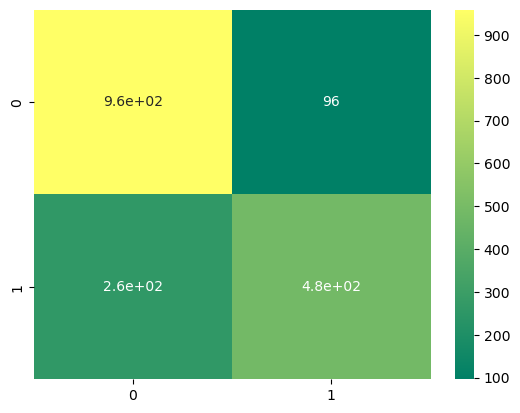

In [37]:
lr_clf = LogisticRegression(random_state=42)

model_accuracy(lr_clf,X_train,X_test,y_train,y_test)

              precision    recall  f1-score   support

         0.0       0.72      0.48      0.57      1055
         1.0       0.50      0.74      0.60       745

    accuracy                           0.58      1800
   macro avg       0.61      0.61      0.58      1800
weighted avg       0.63      0.58      0.58      1800



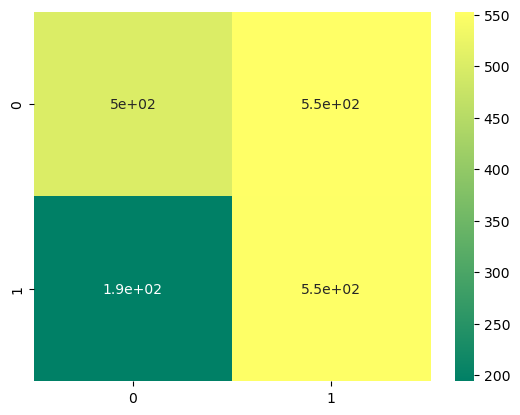

In [38]:
nb_clf = BernoulliNB()

model_accuracy(nb_clf,X_train,X_test,y_train,y_test)

#### Decision Tree Classifier

In [39]:
dt = DecisionTreeClassifier()

params_dt = {
'min_samples_split': range(1,10),
'criterion':['gini','entropy'],
'max_depth': range(1,10),
'min_samples_leaf': range(1,5)
}
# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=dt,
param_grid=params_dt,
scoring= 'r2',
cv=5,
n_jobs=-1)

grid_dt.fit(X_train, y_train)

# Extract best model from 'grid_dt'
best_modelDT = grid_dt.best_params_

In [40]:
DT_final = DecisionTreeClassifier(**best_modelDT)

              precision    recall  f1-score   support

         0.0       0.66      0.85      0.74      1055
         1.0       0.64      0.37      0.47       745

    accuracy                           0.65      1800
   macro avg       0.65      0.61      0.60      1800
weighted avg       0.65      0.65      0.63      1800



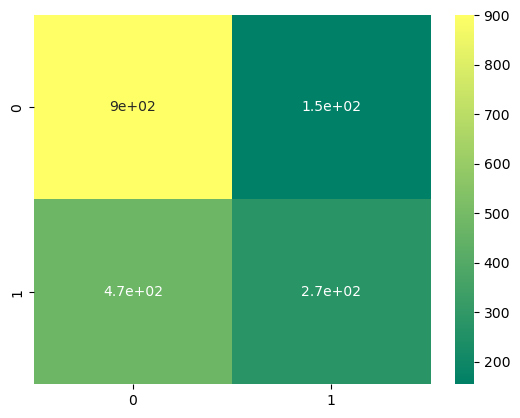

In [41]:
model_accuracy(DT_final,X_train,X_test,y_train,y_test)

#### RandomForest Classifier

In [42]:
rf_model = RandomForestClassifier()


# hyperparameter space
rf_param_grid = dict(
    n_estimators=[10, 20,50,100,150],
    max_depth=[5, 10, 15],
    min_samples_split=[2, 4,5],
    criterion = ['gini', 'entropy'],
#     max_features= ['auto', 'sqrt', 'log2']
)


# search
rf_clf = GridSearchCV(rf_model, rf_param_grid,
                   scoring='r2', cv=5, n_jobs = -1)

rf_clf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 4, 5],
                         'n_estimators': [10, 20, 50, 100, 150]},
             scoring='r2')

In [43]:
best_modelRF = rf_clf.best_params_

In [44]:
rf_final = RandomForestClassifier(**best_modelRF)

              precision    recall  f1-score   support

         0.0       0.69      0.96      0.80      1055
         1.0       0.87      0.40      0.55       745

    accuracy                           0.73      1800
   macro avg       0.78      0.68      0.67      1800
weighted avg       0.77      0.73      0.70      1800



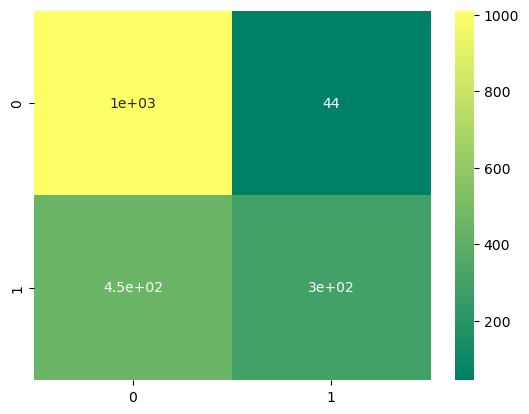

In [45]:
model_accuracy(rf_final,X_train,X_test,y_train,y_test)

#### XGBoost Classifier

In [46]:
param_dist = {
        'n_estimators':range(50,150,5),
        'max_depth':range(2,15,1),
        'learning_rate':np.linspace(0.01,1,25),
        'subsample':np.linspace(0.1,0.9,25),
        'colsample_bytree':np.linspace(0.3,0.8,20),
        'min_child_weight':range(1,9,1),
        'gamma': [0, 0.2,0.25, 0.3,0.35, 0.5, 1.0]

        }


xgbr = XGBClassifier()
XGB_Model = RandomizedSearchCV(xgbr,
                   param_dist,
                   scoring='r2',
                   verbose=1,
                    cv = 5,
                    n_iter=125,
                    n_jobs = -1)
XGB_Model.fit(X_train, y_train)
print("Best parameters:", XGB_Model.best_params_)

best_modelXGB = XGB_Model.best_params_



Fitting 5 folds for each of 125 candidates, totalling 625 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 80, 'min_child_weight': 2, 'max_depth': 10, 'learning_rate': 0.13375, 'gamma': 0.3, 'colsample_bytree': 0.7473684210526315}


In [47]:
xgb_final = XGBClassifier(**best_modelXGB)

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.83      1055
         1.0       0.79      0.65      0.72       745

    accuracy                           0.79      1800
   macro avg       0.79      0.77      0.77      1800
weighted avg       0.79      0.79      0.78      1800



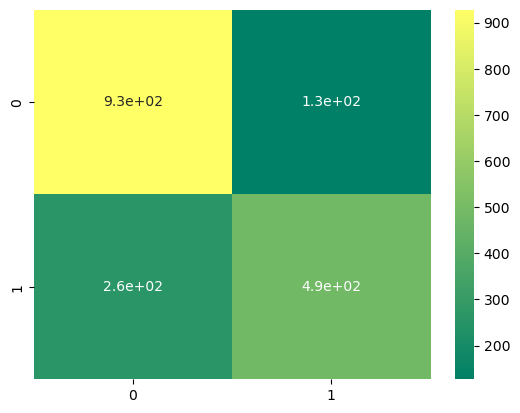

In [48]:
model_accuracy(xgb_final,X_train,X_test,y_train,y_test)